# DSM for *Euler-Bernoulli Beam*

In this note book, we will introduce the basic 1D Euler-Bernoulli beam element in our PyDSMSM library!

Firstly, the necessary libraries and predefined classes will be imported. 


In [1]:
# Import default libraries
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets, HBox, Layout
import scipy.optimize as opt
import pydynsm as PDM

## Useful Function

In [2]:
def plot_vibration_animation(x_real_time, z_real_time, total_duration):
    """
    Creates an animation using the given x_real_time and z_real_time data.
    Ensures z=0 at t=0 while keeping x unchanged. Adds the time (t) in the title.

    Parameters:
        x_real_time (list): x-coordinates of nodes at each time step.
        z_real_time (list): z-coordinates of nodes at each time step.
        total_duration (float): Total duration of the animation in seconds.
    """
    num_frames = len(x_real_time)  # Total number of frames
    time_per_frame = total_duration / num_frames  # Time interval per frame

    # Define the plotting function
    def disp_plot(x, z, step):
        plt.figure(figsize=(8, 4))
        current_time = step * time_per_frame  # Calculate the time for the current frame
        if step == 0:
            # For t=0, plot x with z=0
            plt.plot(x[step], [0] * len(x[step]), lw=2, label="t=0 (z=0)")
        else:
            # For other time steps, plot the actual deformed positions
            plt.plot(x[step], z[step], lw=2, label=f"Time Step {step}")
        plt.title(f"t={current_time:.3f}s")  # Add time in seconds
        plt.xlabel("x [m]")
        plt.ylabel("Displacement, $w$ [m]")
        plt.xlim(min(map(min, x_real_time)) - 0.01, max(map(max, x_real_time)) + 0.01)
        plt.ylim(min(map(min, z_real_time)) - 0.01, max(map(max, z_real_time)) + 0.01)
        plt.show()

    # Create the Play and Slider widgets
    play = widgets.Play(min=0, max=num_frames-1, step=1, interval=50, value=0, disabled=False)
    slider = widgets.IntSlider(min=0, max=num_frames-1, step=1, value=0)

    # Synchronize the Play widget with the Slider widget
    widgets.jslink((play, 'value'), (slider, 'value'))

    # Use interact to create the animation
    interact(disp_plot,
             x=fixed(x_real_time),
             z=fixed(z_real_time),
             step=play)

    # Display the slider widget
    display(HBox([slider]))


## Overview

In this notebook, we will focus on the steady state response of the 1D Euler-Bernoulli Beam under harmonic loading in the figure below. Similarly as previous tutorial book, we have the following tasks:

- Introduce the theory of the Dynamic Stiffness Matrix (DSM) formulation for the **1D Euler-Bernoulli Beam**.
- Explain the implementations of DSM using an example shown in Figure(C1.2).
- Perform a sanity check of reations and displacements and compare them with static cases.
- Visulalize the results in time domain.

<center>
<img src="images_notebook/1d_Euler_Bernoulli_bar.png" alt="f1" >
</center>

> **Figure C1.1**: 1D Euler-Bernoulli Beam with two *free ends*

### Theory


We will introduce DSMs formulations briefly:

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Step 1: Equation of Motion:</b> 

Let us start by consider a 1D Euler-Bernoulli model with two *free ends*:

It has the following form of equation of motion **subjected to dynamic excitations**:

$$
\rho A\frac{\partial^2 w(x,t)}{\partial t^2} + EI\frac{\partial^2 w(x,t)}{\partial x^4} = 0, \quad 0<x<L
$$

If the wave velocity in 1D Euler-Bernoulli Beam $c_\mathrm{b}$ was defined as below:

$$
c_\mathrm{b} = \sqrt{\frac{EI}{\rho A}}
$$

we could rewrite the equation of motion as:

$$
\frac{\partial^2 w(x,t)}{\partial t^2} + c^2_\mathrm{b}\frac{\partial^4 w(x,t)}{\partial x^4} = 0, \quad 0<x<L
$$

</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Step 2: Boundary Conditions:</b> 

Assuming **harmonic nodal forces and displacements**, we have the following boundary conditions at two nodes

*Kinematic Boundary Conditions:*

at $x=0$：

$$
w(0,t) = \widetilde{W}_1\exp{\left(\mathrm{i}\Omega t\right)}
$$

$$
\varphi(0,t) = \widetilde{\varphi}_1\exp{\left(\mathrm{i}\Omega t\right)}
$$

at $x=L$：

$$
w(L,t) = \widetilde{W}_2\exp{\left(\mathrm{i}\Omega t\right)}
$$

$$
\varphi(L,t) = \widetilde{\varphi}_2\exp{\left(\mathrm{i}\Omega t\right)}
$$

*Dynamics Boundary Conditions:*

at $x=0$：

$$
V(0,t) = -\widetilde{F}_1\exp{\left(\mathrm{i}\Omega t\right)}
$$

$$
M(0,t) = -\widetilde{M}_1\exp{\left(\mathrm{i}\Omega t\right)}
$$

at $x=L$：

$$
V(L,t) = \widetilde{F}_2\exp{\left({\mathrm{i}\Omega t}\right)}
$$

$$
M(L,t) = \widetilde{M}_2\exp{\left({\mathrm{i}\Omega t}\right)}
$$
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Step 3: Reduced equation of motions and BCs:</b> 

The steady state solution $u(x,t)$ is defined as below:

$$
w(x,t) = \widetilde{W}(x)\exp{\left(\mathrm{i}\Omega t\right)}.
$$

We can have our EoM alternatively as:

$$
\frac{\mathrm{d}^4 \widetilde{W}(x)}{\mathrm{d} x^4} - \beta^4 \widetilde{W}(x) = 0
$$

where $\displaystyle \beta^4 = \left(\frac{\omega}{c_\mathrm{b}}\right)^2$

Similar operations could be done to get reduced BCs:

*Kinematic Boundary Conditions:*

at $x=0$：

$$
\widetilde{W}(0) = \widetilde{W}_1
$$

$$
\widetilde{\varphi}(0) = \widetilde{\varphi}_1
$$

at $x=L$：

$$
\widetilde{W}(L) = \widetilde{W}_2
$$

$$
\widetilde{\varphi}(L) = \widetilde{\varphi}_2
$$

*Dynamic Boundary Conditions:*

at $x=0$：

$$
-EI\widetilde{W}'''(0) = -\tilde{F}_1 \rightarrow EI\widetilde{W}'''(0) = \widetilde{F}_1
$$

$$
-EI\widetilde{W}''(0) = -\tilde{M}_1 \rightarrow EI\widetilde{W}''(0) = -\widetilde{F}_1
$$

at $x=L$：

$$
-EI\widetilde{W}'''(L) = \widetilde{F}_2
$$

$$
-EI\widetilde{W}''(L) =  \widetilde{M}_1
$$


</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Step 4: Forming DSM:</b> 

Generally, we successfully reduced our PDE to ODE in frequency domain:

the general solution of reduced EoM is given as:

$$
\widetilde{W}(x) = C_1\exp\left(-\mathrm{i}\beta_1 x\right) + C_2\exp\left(-\mathrm{i}\beta_2 x\right) + C_3\exp\left(-\mathrm{i}\beta_3 x\right) + C_4\exp\left(-\mathrm{i}\beta_4 x\right)
$$

Subtitute above into *Kinematic Boundary Conditions*, we have $\mathbf{U}=\mathbf{A}\mathbf{C}$

$$
\begin{bmatrix}
    \widetilde{W}_1 \\
    \widetilde{\varphi}_1 \\
    \widetilde{W}_2 \\
    \widetilde{\varphi}_2
\end{bmatrix} =
\begin{bmatrix}
    A_{11}& A_{12}& A_{13}& A_{14} \\
    A_{21}& A_{22}& A_{23}& A_{24} \\
    A_{31}& A_{32}& A_{33}& A_{34} \\
    A_{41}& A_{42}& A_{43}& A_{44}
\end{bmatrix}
\begin{bmatrix}
    C_1 \\
    C_2 \\
    C_3 \\
    C_4
\end{bmatrix}
$$


Similarly Operations to *Dynamic Boundary Conditions*, we have $\mathbf{F}=\mathbf{D}\mathbf{C}$

$$
\begin{bmatrix}
    \widetilde{F}_1 \\
    \widetilde{M}_1 \\
    \widetilde{F}_2 \\
    \widetilde{M}_2
\end{bmatrix}=
\begin{bmatrix}
    D_{11}& D_{12}& D_{13}& D_{14} \\
    D_{21}& D_{22}& D_{23}& D_{24} \\
    D_{31}& D_{32}& D_{33}& D_{34} \\
    D_{41}& D_{42}& D_{43}& D_{44}
\end{bmatrix}
\begin{bmatrix}
    C_1 \\
    C_2 \\
    C_3 \\
    C_4
\end{bmatrix}
$$

Finally, we could have the expression for relationship between $\mathbf{F}$ and $\mathbf{U}$, which is

$$
\mathbf{F} = \left(\mathbf{D}\mathbf{A}^{-1}\right)\mathbf{U}=\mathbf{K}_\mathrm{d}\mathbf{U}
$$

where $\mathbf{K}_\mathrm{d} = \mathbf{D}\mathbf{A}^{-1}$ is the **Dynamic stiffness matrix**.


</div>

Let us try to implement the method using example below:

<center>
<img src="images_notebook/notebook2_example.png" alt="f1">
</center>

> **Figure C1.2**: 1D Euler-Bernoulli Beam with *one fixed end*, under a single point load

### Implementations

Our DSM method implementation is now completely stored in a local package, consisting of a few classes. If you need a refresher on how to code with Classes and Objects, refer to the [MUDE book on Object Oriented Programming](https://mude.citg.tudelft.nl/2023/book/external/learn-python/other_python_stuff/year2/python_topics/classes.html). 

But without a deep understanding of OOP, you could still successfully apply them by following steps here!

Assume we have the load (think about how to do that!) and EoMs in freqeuncy domain:

- Initialize assembler and define properties
- Create nodes and elements
- Add constraints
- Set Sections
- Define load (in frequency domain)
- Assemble Global force vector and stiffness matrix
- Obtain Constrained Matrices
- Solve the algebric system of equations (in frequency domain)

If time domain response is required:

- Find the response in the time domain using the Inverse Fourier Transform (initial conditions are zero and system has damping).

In [3]:
# Initialize the Assembler

Assembler = PDM.Assembler  #Import the Assembler class from the PDM module

s1 = Assembler('1D EB',analysis_type='new')

Assembler '1D EB' successfully initialised


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Define properties:</b> 

Then we define some parameters here, which would be used as material properties later:

</div>

In [4]:
# define material properties here
E = 2.1e11                               # Young's modulus
A = 1/3000                               # Cross-sectional area
I = 1.5 * 7e06/E                         # Moment of inertia
rho = 3e6                                # Density
ksi = 0.01                                  # Damping coefficient
# define geometrical properties here
L = 1                                    # Length of the rod

# define loading parameters here
F_0 = 1e06 + 0j                          # Force amplitude                                  
Omega = 100                              # Force frequency

In [5]:
node1 = s1.CreateNode(0,0)
node2 = s1.CreateNode(L,0)
elem = s1.CreateElement([node1, node2])

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

Finally, we could visualize created nodes and elements by using function `Plotstructure()`

</div>

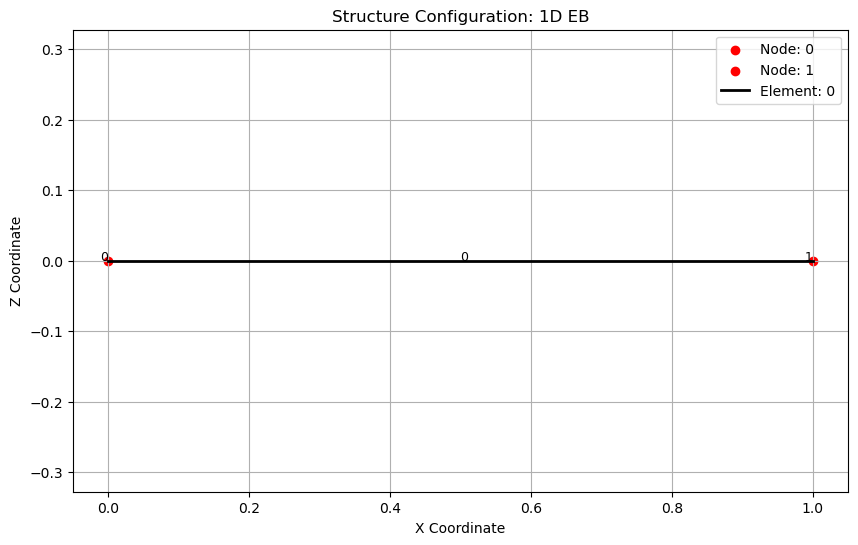

In [6]:
s1.PlotStructure(plot_elements=True)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Add constraints:</b> 

Next step is to fix node1 in all 3 directions and node2 in $x$ direction, we have several ways to do that !


let us firstly try `fix_node()` function from `node` class, which is used to fix all DoFs of given node.

</div>

In [7]:
node1.fix_node('x','z','phi_y')
node2.fix_node('x')

Global DOF 'x' for node 0 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 0 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 0 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Global DOF 'x' for node 1 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Set section:</b> 

After drawing element, we want set *section properties* for the element here.

In our method, element could be characterised by `element type` and `element properties`.

Here we use `set_section(element type, element properties)`, where `element type` should be `Rod` if we want to draw a *1D rod* as shown in Figure C1.1. 

Besides, it is also supposed to have some material properties like `E` ($E$), `rho` ($\rho$), `A` ($A$),  `I` ($I$), and `ksi`($\xi$)

</div>

In [8]:
elem.SetSection('EulerBernoulli Beam', {'E': E, 'rho':rho, 'A':A, 'Ib':I, 'ksi':ksi})	

Successfully added element of type: EulerBernoulli Beam to Element 0


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Set section:</b> 

Run cell above, you should see

`Successfully added element of type: EulerBernoulli Beam to Element 0`

which suggests that the element has been defined successfully in terms of their `type` and `properties`.

</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Define load in frequency domain:</b> 

Now we want to define a harmonic load $F_0\cos(\Omega t)$ in frequency domain by **Fourier Transform**.

</div>

In [9]:
F_omega = lambda omega: F_0 if omega == Omega else 0

# Generate the range of omega values
omega_values = np.linspace(1, 2001, 2001)
F_values_lambda = [F_omega(omega) for omega in omega_values]

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

<b>Add load</b>

It seems the load has been defined correctly in frequency domain before being added to the free node here. Normally, we did it by using function `.add_load(x=F_x,y=F_y,z=F_z)` under `node` class.

</div>

In [10]:
node2.add_load(z=F_omega)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Conectivity informaion</b>

It seems the load has been defined correctly in frequency domain before being added to the free node here. Normally, we did it by using function `.add_load(x=F_x,y=F_y,z=F_z)` under `node` class.

</div>

In [11]:
s1.run_connectivity()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Get the global stiffness and force:</b> 

Since `node`, `element` and load have already be well-defined, now we want to assemble the **global dynamic stiffness matrix $\mathbf{K}_\mathrm{d}(\Omega)$** and **Force vector $\mathbf{F}$**.

</div>

In [12]:
K_global = s1.GlobalStiffness(Omega)
F_global = s1.GlobalForce(Omega)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Obtain constrained global stiffness and force:</b> 

Now we want to get constrained **global dynamic stiffness matrix** `Kc_global` and **Force vector** `Fc_global` in terms of *dirichilet boundary conditions*. 
</div>

In [13]:
Kc_global = s1.GlobalConstrainedStiffness(Omega)
Fc_global = s1.GlobalConstrainedForce(Omega)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Solve free-end displacement:</b> 

Now we want to solve free end displacement $\mathbf{u}_{f}$ when $\omega = \Omega$ based on:

$$
\mathbf{K}_{ff}(\Omega)\mathbf{u}_f(\Omega)=\mathbf{f}_f(\Omega)-\mathbf{K}_{fc}(\Omega)\mathbf{u}_c(\Omega) \Rightarrow \mathbf{u}_f(\Omega)=\mathbf{K}^{-1}_{ff}(\Omega)\left\{\mathbf{f}_f(\Omega)-\mathbf{K}_{fc}(\Omega)\mathbf{u}_c(\Omega)\right\}
$$

Our equation solver `.SolveUfree(Kc_globa,Fc_global)` implements idea above.
</div>

In [14]:
u_free = s1.SolveUfree(Kc_global, Fc_global)

In [15]:
print(f'The free end solution is {u_free}')
print(f'The free end vertical displacement is {u_free[0].real} m')
print(f'The free end vertical rotation is {u_free[1].real} rad')

The free end solution is [ 0.03431974+7.75848400e-18j -0.05116721-1.63685594e-17j]
The free end vertical displacement is 0.03431974275102383 m
The free end vertical rotation is -0.05116720722212713 rad


### Sanity check in Frequency Domain

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Check Displacement and Reactions:</b> 

It's a good time to check the sanity of our method.

Now make our harmonic excitation to have a single amplitude $\hat{F}_0$ at all frequencies, then we will compute and plot

- Free end displacement
- Recations at fixed end

over the freuqency range $\omega_\mathrm{test} = [0,1000] \text{ rad/s}$.

</div>

In [16]:
omega_values_check_test = np.linspace(1, 1001, 1001)

displacements_check = []
rotations_check = []
reaction_check = []
moment_check = []

s2 = Assembler('1D Rod',analysis_type='new')

node3 = s2.CreateNode(0,0)
node4 = s2.CreateNode(L,0)
elem2 = s2.CreateElement([node3, node4])

node3.fix_node('x','z','phi_y')
node4.fix_node('x')
elem2.SetSection('EulerBernoulli Beam', {'E': E, 'rho':rho, 'A':A, 'Ib':I, 'ksi':ksi})
s2.run_connectivity()

node4.add_load(z=F_0)

for omega_test in omega_values_check_test:

    K_global_test = s2.GlobalStiffness(omega_test)
    F_global_test = s2.GlobalForce(omega_test)

    Kc_global_test = s2.GlobalConstrainedStiffness(omega_test)
    Fc_global_test = s2.GlobalConstrainedForce(omega_test)

    w_free = s2.SolveUfree(Kc_global_test, Fc_global_test) # Free end solution
    R_fix =  s2.SupportReactions(K_global_test,w_free,F_global_test) # Reaction forces at the fixed end

    displacements_check.append(w_free[0])
    rotations_check.append(w_free[1])
    reaction_check.append(R_fix[1])
    moment_check.append(R_fix[2])


Assembler '1D Rod' successfully initialised
Global DOF 'x' for node 2 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 2 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 2 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Global DOF 'x' for node 3 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Successfully added element of type: EulerBernoulli Beam to Element 1


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>


Running the code below and observe generated results, try to consider the following question **if you are interested**:

- What are physical meanings of $\mathrm{Re}(u)$ and $\mathrm{Im}(u)$?
- What is the value of $\mathrm{Re}(u)$ when $\omega\!=\!0$? Does it match the displacement under static loading? (**Hint:**  $\displaystyle w_\mathrm{static} = \hat{F}_0L^3/\tilde{E}I$)
- Consider the free vibrations of a 1d Euler-Bernoulli system with one fixed end, derive its natural frequencies, does it match the position of peak here? 
- You should also see sharp changes of $\mathrm{Re}(u)$ and $\mathrm{Im}(u)$ those locations, think about steady state response of mass-spring system under forced vibration, why there are shifts?

**Hint**: the natural frequencies $\omega_n$ of the system here should be (try to do rough check by ignoring material damping, *i.e.* $\tilde{E} = E$)

 $$
 \omega_n = \beta^2_n \sqrt{\frac{EI}{\rho A}}\quad \text{for }n= 1,2,3,\dots
$$

</div>

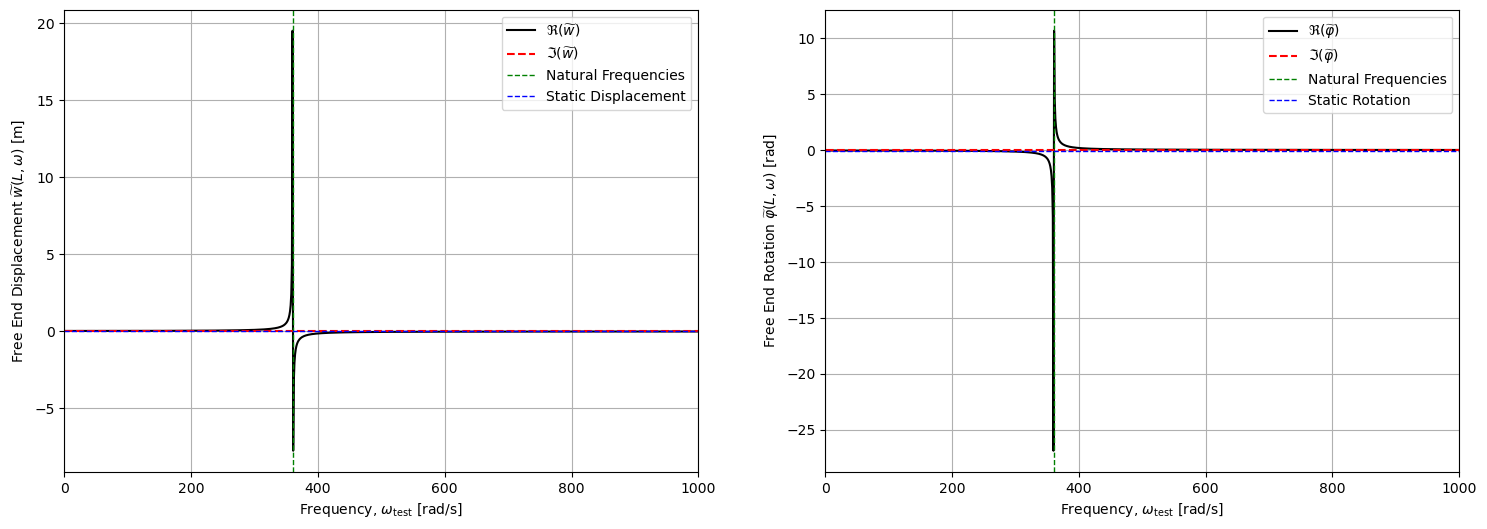

In [17]:
# Calculate natural frequencies

n_index = np.arange(0, 4)
c_index = [3.52,22.4,61.7,120.8] # from lecture notes no.15
natural_frequencies = []

for n in n_index:
    E_complex = E * (1 + 2 * 1j * ksi)
    c_b = c_index[n]
    # print(f'c_b = {c_b}')
    omega_n = c_b/L**2 * np.sqrt(E_complex * I / (rho * A))
    natural_frequencies.append(omega_n)

# Calculate limiting case under static loading
w_static = F_0*L**3/(3*E * (1 + 2 * 1j * ksi)*I)
phi_static = -F_0*L**2/(2*E * (1 + 2 * 1j * ksi)*I)

# Plot all the results
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(18,6))

axs[0].plot(omega_values_check_test, [w.real for w in displacements_check], 'k', label=r'$\Re(\widetilde{w})$')
axs[0].plot(omega_values_check_test, [w.imag for w in displacements_check], 'r--', label=r'$\Im(\widetilde{w})$')

axs[1].plot(omega_values_check_test, [phi.real for phi in rotations_check], 'k', label=r'$\Re(\widetilde{\varphi})$')
axs[1].plot(omega_values_check_test, [phi.imag for phi in rotations_check ], 'r--', label=r'$\Im(\widetilde{\varphi})$')

for i, omega_n in enumerate(natural_frequencies):
    if i == 0:
        axs[0].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1, label='Natural Frequencies')
        axs[1].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1, label='Natural Frequencies')
    else:
        axs[0].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1)
        axs[1].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1)

axs[0].axhline(y=w_static.real, color='b', linestyle='--', linewidth=1, label='Static Displacement')
axs[1].axhline(y=phi_static.real, color='b', linestyle='--', linewidth=1, label='Static Rotation')

axs[0].set_xlabel(r'Frequency, $\omega_\mathrm{test}$ [rad/s]')
axs[0].set_ylabel(r'Free End Displacement $\widetilde{w}(L,\omega)$ [m]')

axs[1].set_xlabel(r'Frequency, $\omega_\mathrm{test}$ [rad/s]')
axs[1].set_ylabel(r'Free End Rotation $\widetilde{\varphi}(L,\omega)$ [rad]')

for ax in axs:
    ax.set_xlim(0, 1000)
    ax.legend()
    ax.grid(True)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Reactions Plots:</b> 

Now we check the moment and vertical reaction of the beam at the fix-end.



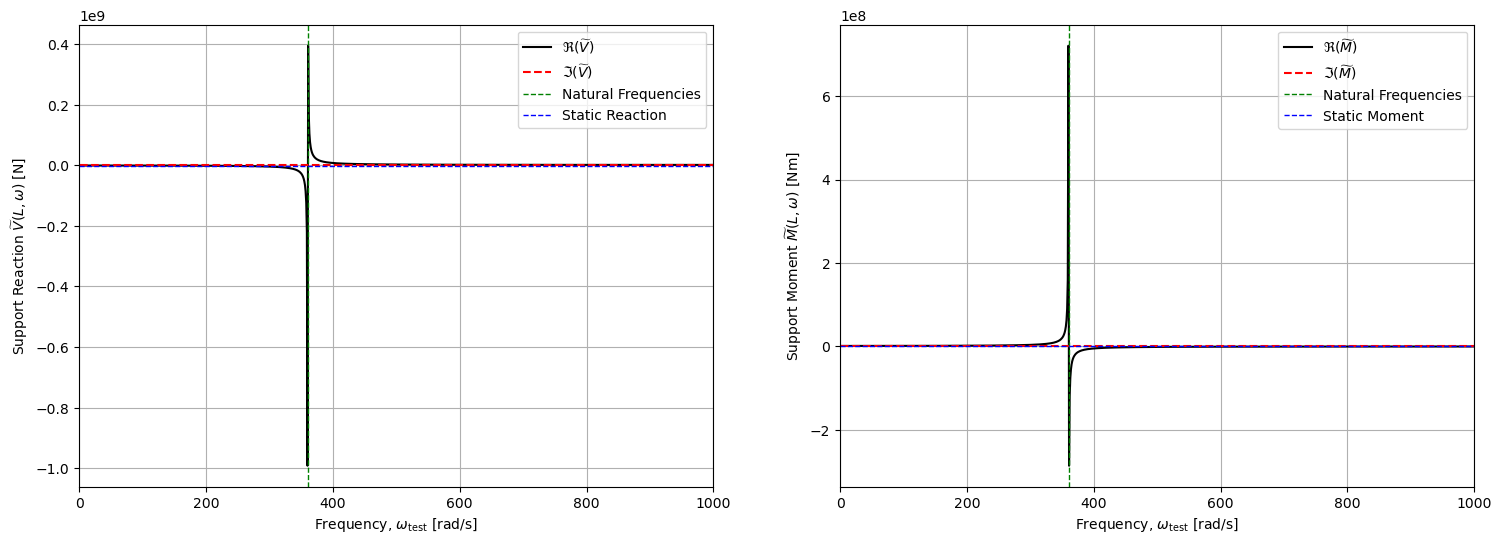

In [18]:
# Plot all the results
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(18,6))

# Calculate limiting case under static loading
v_static = -F_0
m_static = F_0*L

axs[0].plot(omega_values_check_test, [V.real for V in reaction_check], 'k', label=r'$\Re(\widetilde{V})$')
axs[0].plot(omega_values_check_test, [V.imag for V in reaction_check], 'r--', label=r'$\Im(\widetilde{V})$')

axs[1].plot(omega_values_check_test, [M.real for M in moment_check], 'k', label=r'$\Re(\widetilde{M})$')
axs[1].plot(omega_values_check_test, [M.imag for M in moment_check], 'r--', label=r'$\Im(\widetilde{M})$')

for i, omega_n in enumerate(natural_frequencies):
    if i == 0:
        axs[0].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1, label='Natural Frequencies')
        axs[1].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1, label='Natural Frequencies')
    else:
        axs[0].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1)
        axs[1].axvline(x=omega_n.real, color='g', linestyle='--', linewidth=1)


axs[0].axhline(y=v_static.real, color='b', linestyle='--', linewidth=1, label='Static Reaction')
axs[1].axhline(y=m_static.real, color='b', linestyle='--', linewidth=1, label='Static Moment')

axs[0].set_xlabel(r'Frequency, $\omega_\mathrm{test}$ [rad/s]')
axs[0].set_ylabel(r'Support Reaction $\widetilde{V}(L,\omega)$ [N]')
axs[1].set_xlabel(r'Frequency, $\omega_\mathrm{test}$ [rad/s]')
axs[1].set_ylabel(r'Support Moment $\widetilde{M}(L,\omega)$ [Nm]')
for ax in axs:
    ax.set_xlim(0, 1000)
    ax.legend()
    ax.grid(True)

### Time domain response

We are near the end of this notebook, which is computing and visulazing *time domain response*.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Compute time Domain Response</b> (IFFT is working with zero imag part in time domain, define it to be a function later)

We firstly got frequency domain response of free-end vertical displacement $\widetilde{w}(x,\omega)$, then transfer it back to time domain using `np.fft.ifft`.

If you need a refresher on *Discrete Fourier Transform* (DFT), see [MUDE book on Discrete Fourier Transform](https://mude.citg.tudelft.nl/2024/book/signal/dft.html).
</div>

In [19]:
s3 = Assembler('1D EB - Time Domain',analysis_type='new')
node5 = s3.CreateNode(0,0)
node6 = s3.CreateNode(L,0)
elem3 = s3.CreateElement([node5, node6])
node5.fix_node('x','z', 'phi_y')
node6.fix_node('x')
elem3.SetSection('EulerBernoulli Beam', {'E': E, 'rho':rho, 'A':A, 'Ib':I, 'ksi':ksi})


# Define the force function
omega_F = 100
F_omega = lambda omega: F_0 if omega == omega_F else 0
node6.add_load(z=F_omega)
s3.run_connectivity()
# Step 1: Define parameters
N_positive = 1601  # Number of positive frequencies (1 to 5001)
omega_positive = np.linspace(1, 1601, N_positive)  # Positive frequency range: 1 to 5001
N_total = 2 * N_positive # Total points (symmetric, excluding 0)

# Step 2: Create symmetric frequency range
omega_negative = np.linspace(-1601, -1, N_positive)  # Negative frequency range: -5001 to -1
omega_values = np.concatenate([omega_negative, omega_positive])  # Full symmetric frequency range

Assembler '1D EB - Time Domain' successfully initialised
Global DOF 'x' for node 4 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Global DOF 'z' for node 4 updated to 0.
Global DOF 'z' with value '0' applied to connected elements.
Global DOF 'phi_y' for node 4 updated to 0.
Global DOF 'phi_y' with value '0' applied to connected elements.
Global DOF 'x' for node 5 updated to 0.
Global DOF 'x' with value '0' applied to connected elements.
Successfully added element of type: EulerBernoulli Beam to Element 2


In [20]:
w_free_frequency_positive = []
# u_free_frequency = lambda omega: u_free[0] if omega == omega_F else 0
for omega in omega_positive:
    K_global_test3 = s3.GlobalStiffness(omega)
    F_global_test3 = s3.GlobalForce(omega)
    Kc_global_test3 = s3.GlobalConstrainedStiffness(omega)
    Fc_global_test3 = s3.GlobalConstrainedForce(omega)
    # Free end solution
    w_free = s3.SolveUfree(Kc_global_test3, Fc_global_test3) # Free end solution
    w_full = s3.FullDisplacement(w_free)
    displacement = elem3.Displacements(w_full,100,20)
    w_free_frequency_positive.append(w_free[0])

In [21]:
print(w_full)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [22]:
# Step 2: Add X_0 = 0 to account for zero mean
w_zero_mean = [0.0]  # Zero mean component

# Step 3: Add complex conjugates for negative frequencies in reverse order
w_free_frequency = np.concatenate([
    w_zero_mean,
    w_free_frequency_positive,  # Positive frequencies
    np.conj(w_free_frequency_positive[::-1])  # Negative frequencies
])


In [23]:
# Frequency-domain parameters
domega = omega_values[1] - omega_values[0]  # Angular frequency step
df = domega / (2 * np.pi)                   # Frequency step
N = len(w_free_frequency)          # Length of frequency-domain data
dt = 1 / (df * N)                           # Time step

# Create time vector matching the length of w_free_frequency
t = np.linspace(0, N * dt, N)

# Perform IFFT
w_free_time = np.fft.ifft(w_free_frequency)*0.5*N # Ensure real-valued time-domain result

omega_final = np.concatenate([
[0],omega_positive,omega_negative
])

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Plot Time Domain Response</b> 

Running codes below should give $w(L,t)$ in time domain.

</div>

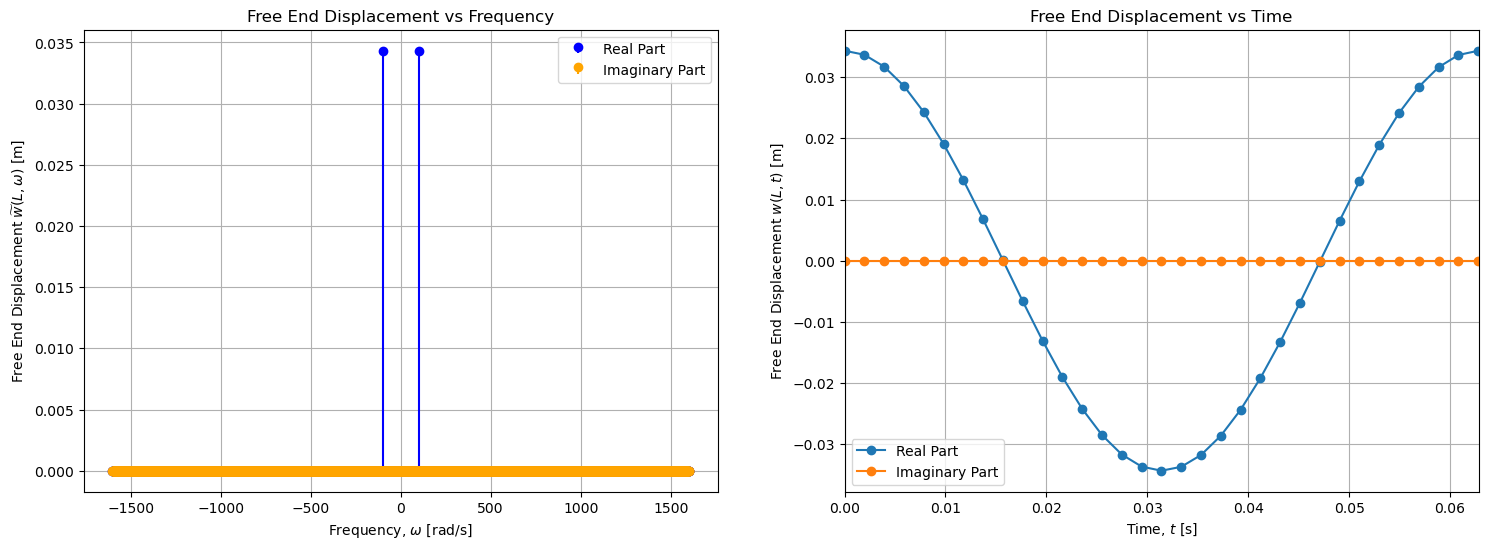

In [24]:
# Plot the displacement in time and frequency domain
fig, axs = plt.subplots(1, 2, figsize=(18,6))

axs[1].plot(t, np.real(w_free_time),'o-',label="Real Part")
axs[1].plot(t, np.imag(w_free_time),'o-',label="Imaginary Part")
axs[1].set_xlabel('Time, $t$ [s]')
axs[1].set_ylabel('Free End Displacement $w(L,t)$ [m]')
axs[1].set_title('Free End Displacement vs Time')
axs[1].grid(True)

axs[0].stem(omega_final, [w.real for w in w_free_frequency], basefmt=" ", linefmt="b-", markerfmt="bo", label="Real Part")
axs[0].stem(omega_final, [w.imag for w in w_free_frequency], basefmt=" ", linefmt="orange", markerfmt="o", label="Imaginary Part")
axs[0].set_ylabel(r'Free End Displacement $\widetilde{w}(L,\omega)$ [m]')
axs[0].set_xlabel(r'Frequency, $\omega$ [rad/s]')
axs[0].set_title('Free End Displacement vs Frequency')
axs[0].grid(True)

for ax in axs:
    ax.legend()

axs[1].set_xlim(0, 2*np.pi/omega_F);

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b> Animations</b> 

Running codes below gives the animation of beam displacement. (not working, check it later)

</div>

In [25]:
# x = np.linspace(0, L, 20)
# x_real_time = []
# z_real_time = []
# for i in range (0, len(displacement_time)):
#     u_vector = displacement_time[i,:,:]
#     u_x_real = u_vector[0,:].real
#     u_z_real = u_vector[1,:].real
#     x_time = x + u_x_real
#     z_time = u_z_real
#     x_real_time.append(x_time)
#     z_real_time.append(z_time)

In [26]:
# total_duration = 2.0  # Total duration in seconds (e.g., 2 seconds)
# # Call the function
# plot_vibration_animation(x_real_time, z_real_time, total_duration)